## Main File

This notebook containes the processing chain for our spatial algorithms project. 
To run this code the classes.py file is needed. 

In [1]:
#Libraries
from classes import *
import pandas as pd # Used to Export Data to csv format, so long processing steps only have to be done once


## Read in Data

Short description what happens and how

In [4]:
# Define Paths
data1_path = "data/Polygons_no_mountains.geojson"
data2_path = "data/Polygons_with_mountains.geojson"
data3_path = "data/swissnames_points_json_export.geojson"

# Define Json Files
json_files = [(data1_path, "Gemeinden_ohne_Berge"),
(data2_path, "Gemeinden_mit_Berge"),
(data3_path, "Swissnames_Points")]


In [5]:
# Read Data
data = process_json_file(json_files)

## Preprocessing

Consists of the following steps:
- The Polygon_data Class is created, which is basically an object storing multiple lists of polygons.
- The remove_unique_entries filters all polygons, which occur only in one of the two given lists. This seemes to be an issue of the raw data and the fact, that our algorithm cannot handle multipolygons. In this step, the lists are also being sorted by their Municipality ID. The result is therefore two lists of the same length, where the municipality polygons are in the same order.
- The Last step uses the apply_difference function, which iterates over both lists and comuptes the pairwise polygon difference. By doing this, we do not have to do complete layer calculations, and save immense processing costs.

In [6]:
polygon_data = Polygon_Data(data['Gemeinden_mit_Berge'],data['Gemeinden_ohne_Berge'])

In [7]:
polygon_data.remove_unique_entries()

10 unique objects removed from municipalities_polygons:
Polygon Zwieselberg consisting of 6 points BFS_Nr=947
Polygon Wangenried consisting of 6 points BFS_Nr=993
Polygon Escholzmatt-Marbach consisting of 23 points BFS_Nr=1010
Polygon Lüterswil-Gächliwil consisting of 9 points BFS_Nr=2456
Polygon Bergün Filisur consisting of 36 points BFS_Nr=3544
Polygon Turgi consisting of 9 points BFS_Nr=4042
Polygon Novaggio consisting of 11 points BFS_Nr=5207
Polygon Törbel consisting of 11 points BFS_Nr=6296
Polygon Beurnevésin consisting of 7 points BFS_Nr=6773
Polygon Bonfol consisting of 9 points BFS_Nr=6775

16 unique objects removed from muns_only_vegetation_area_polygons:
Polygon Valsot consisting of 43 points BFS_Nr=3764
Polygon Ponte Capriasca consisting of 6 points BFS_Nr=5212
Polygon Rüeggisberg consisting of 17 points BFS_Nr=880
Polygon Zuoz consisting of 8 points BFS_Nr=3791
Polygon Samedan consisting of 14 points BFS_Nr=3786
Polygon Madulain consisting of 8 points BFS_Nr=3783
Polygon 

In [8]:
# Polygon Difference
municipalities_mountain_area = polygon_data.apply_difference()

## Point in Polygon Matching

In this section a list of points are checked for spatial containemnt within a list of polygons. 

In [9]:
# Read Points into list
point_data = data['Swissnames_Points']

In [10]:
# Flatten Lists and remove polygons smaller than 100 m^2 (Intersection Artifacts)
municipalities_mountain_area_flattened_list = [item for sublist in municipalities_mountain_area for item in sublist if item.area() >= 100]

In [9]:
# The function returns a list containing polygon id, point id, point name and point type
# !!!Warning: Long Processing Time!!! (10 Minutes on Apple M2 Chip)

result_only_veg = point_polygon_matching(point_data,polygon_data.cleaned_mun_only_vegetation_polys)

result_full_polys = point_polygon_matching(point_data,polygon_data.cleaned_mun_polys)

result_mountain_polys = point_polygon_matching(point_data,municipalities_mountain_area_flattened_list)

In [10]:
# Save DataFrame to CSV file
result_only_veg_df = pd.DataFrame(result_only_veg)
result_only_veg_df.to_csv('data/matched_points_vegetation.csv', index=False)

result_mountain_polys_df = pd.DataFrame(result_mountain_polys)
result_mountain_polys_df.to_csv('data/matched_points_mountain.csv', index=False)

result_full_polys_df = pd.DataFrame(result_full_polys)
result_full_polys_df.to_csv('data/matched_points_full.csv', index=False)

In [2]:
# Read CSV
vegetation = pd.read_csv('data/matched_points_vegetation.csv')
mountains = pd.read_csv('data/matched_points_mountain.csv')
full = pd.read_csv('data/matched_points_full.csv')

# Rename Columns
vegetation.rename(columns={'0': 'polygon_id', '1': 'point_id', '2': 'name', '3': 'objektart'}, inplace=True)
mountains.rename(columns={'0': 'polygon_id', '1': 'point_id', '2': 'name', '3': 'objektart'}, inplace=True)
full.rename(columns={'0': 'polygon_id', '1': 'point_id', '2': 'name', '3': 'objektart'}, inplace=True)

# Grouping and counting for the vegetation dataframe
vegetation_grouped = vegetation.groupby(['polygon_id', 'objektart']).size().reset_index(name='point_count')

# Grouping and counting for the mountains dataframe
mountains_grouped = mountains.groupby(['polygon_id', 'objektart']).size().reset_index(name='point_count')

# Grouping and counting for the full dataframe
full_grouped = full.groupby(['polygon_id', 'objektart']).size().reset_index(name='point_count')

# Print Example
print(vegetation_grouped)

      polygon_id objektart  point_count
0              1  Bergname            2
1              1  Flurname          108
2              2  Bergname            1
3              2  Flurname          193
4              3  Bergname            1
...          ...       ...          ...
3418        6809  Flurname          544
3419        6810  Bergname            5
3420        6810  Flurname          461
3421        6811  Bergname            1
3422        6811  Flurname          142

[3423 rows x 3 columns]


## Join Data and Visualisation

The data is rejoined with its polygon geometries, normalized for area and visualised. 

In [11]:
#join the dataframes with the two additional attributes with the polygons via the polygon_id
polygon_data.join_csv(full_grouped, vegetation_grouped, mountains_grouped)

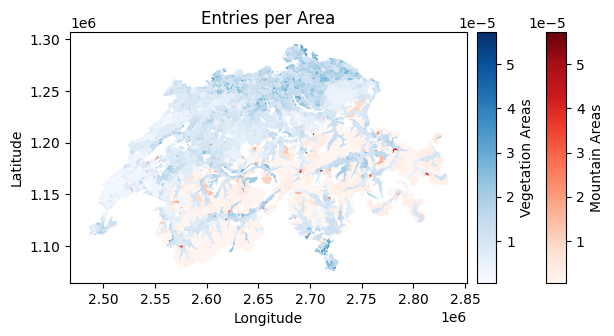

In [12]:
#create a map for both types of polygons (vegetation and mountain areas)
polygon_data.plot_poly_both()

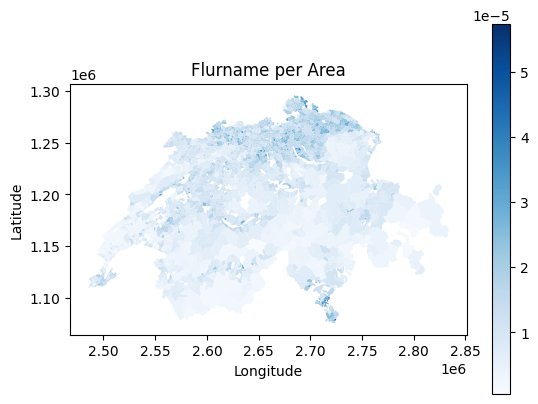

In [13]:
#create a map plot for the points in polygons with "Flurnamen" objektarten
polygon_data.plot_obj_flur()

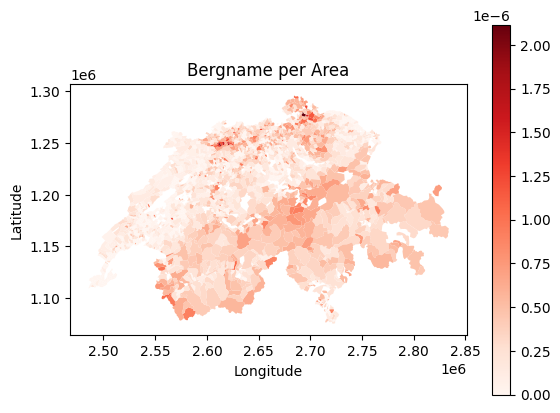

In [14]:
#create a map plot for the points in polygons with "Bergnamen" objektarten
polygon_data.plot_obj_berg()